In [1]:
import time
import datetime

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Load data

In [2]:
participant_df = pd.read_csv(f'./raw_data/participant.csv')
participant_df.head()

,id,creation_date,participant_group,participant_type,submission_date,answers_d1,answers_d2,demographic_info
0,cGlsb3RfcGFydGVjaXBhbnRlXzE=,2024-06-26 19:46:50.921525,C,REGULAR,2024-06-26 20:02:24.076258,c739006a-8253-4f0e-b9b6-4b04c634cc7c,71a3ac08-7168-4d16-9e87-64dc0f48d543,a8f15cb2-1209-402b-8811-cf8c8868dadc
1,cGlsb3RfcGFydGVjaXBhbnRlXzI=,2024-06-26 19:47:07.712534,D,REGULAR,2024-06-26 19:59:43.827209,bf02590a-1275-4dda-94f4-c3e0f443c2ed,24fb4e04-324b-4b4b-af2d-5bb7742f6792,768ecc0b-30fa-42ff-bdaa-760d38ffcdb7
2,cGlsb3RfcGFydGVjaXBhbnRlXzM=,2024-06-26 19:45:54.642664,A,REGULAR,2024-06-26 20:18:29.838274,440f6438-877f-41e9-90e5-8e0f553ea93b,bfea6c6f-8536-4df9-bedd-9f90a7a6d743,66a33a16-7bf3-4240-810c-042e18785dce
3,cGlsb3RfcGFydGVjaXBhbnRlXzQ=,2024-06-26 19:46:49.587677,B,REGULAR,2024-06-26 20:07:57.630823,15820e4a-d1a0-4a0f-ace7-0fc60a1f62ab,a21ce22c-1d12-4787-90bd-46d3732d291e,ac7e36bd-7813-4809-931b-15d76b077655


In [3]:
survey_event_df = pd.read_csv(f'./raw_data/survey_event.csv')
survey_event_df.head()

,id,event,timestamp,participant
0,1,d1 | invisible | q2,1719431165964,cGlsb3RfcGFydGVjaXBhbnRlXzM=
1,2,d1 | invisible | q5,1719431165964,cGlsb3RfcGFydGVjaXBhbnRlXzM=
2,3,d1 | hover | text,1719431166206,cGlsb3RfcGFydGVjaXBhbnRlXzM=
3,4,d1 | leave | text,1719431190605,cGlsb3RfcGFydGVjaXBhbnRlXzM=
4,5,d1 | invisible | q3,1719431165964,cGlsb3RfcGFydGVjaXBhbnRlXzM=


# Flow by participant

In [4]:
CHARTS_TYPE = ['text', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']

In [5]:
def get_events_list(df, participant_id, start_ts):
  sub_df = df[survey_event_df['participant'] == participant_id]
  sub_df = sub_df.sort_values('timestamp')
  sub_df['timestamp'] = (sub_df['timestamp'] / 1e3 / 60) - start_min
  sub_df = sub_df.rename(columns={'event': 'name', 'timestamp': 't'})
  sub_df = sub_df[['t', 'name']]
  return sub_df.to_dict(orient='records')

In [6]:
def evaluate_spans(_events_list):
  # labs spans
  survey_load = next(e['t'] for e in _events_list if e['name'] == 'survey | load')
  lab1_submit = next(e['t'] for e in _events_list if e['name'] == 'survey | lab1 submit')
  lab2_submit = next(e['t'] for e in _events_list if e['name'] == 'survey | lab2 submit')
  lab1_span = (survey_load, lab1_submit)
  lab2_span = (lab1_submit, lab2_submit)

  # visibility_stapns
  d1_visibility_spans = {}
  d2_visibility_spans = {}
  for TYPE in CHARTS_TYPE:
    visibles = [e['t'] for e in _events_list if e['name'] == f'd1 | visible | {TYPE}']
    invisibles = [e['t'] for e in _events_list if e['name'] == f'd1 | invisible | {TYPE}' and e['t'] > visibles[0]]
    d1_visibility_spans[TYPE] = [(visibles[i], invisibles[i]) for i in range(min(len(visibles), len(invisibles)))]

    visibles = [e['t'] for e in _events_list if e['name'] == f'd2 | visible | {TYPE}']
    invisibles = [e['t'] for e in _events_list if e['name'] == f'd2 | invisible | {TYPE}' and e['t'] > visibles[0]]
    d2_visibility_spans[TYPE] = [(visibles[i], invisibles[i]) for i in range(min(len(visibles), len(invisibles)))]

  # hover_spans
  d1_hover_spans = {}
  d2_hover_spans = {}
  for TYPE in CHARTS_TYPE:
    hovers = [e['t'] for e in _events_list if e['name'] == f'd1 | hover | {TYPE}']
    leaves = [e['t'] for e in _events_list if e['name'] == f'd1 | leave | {TYPE}' and e['t'] > hovers[0]]
    d1_hover_spans[TYPE] = [(hovers[i], leaves[i]) for i in range(min(len(hovers), len(leaves)))]

    hovers = [e['t'] for e in _events_list if e['name'] == f'd2 | hover | {TYPE}']
    leaves = [e['t'] for e in _events_list if e['name'] == f'd2 | leave | {TYPE}' and e['t'] > hovers[0]]
    d2_hover_spans[TYPE] = [(hovers[i], leaves[i]) for i in range(min(len(hovers), len(leaves)))]

  return lab1_span, lab2_span, d1_visibility_spans, d2_visibility_spans, d1_hover_spans, d2_hover_spans

In [7]:
def evaluate_points(_events_list):
  # question points
  d1_question_points = {}
  d2_question_points = {}

  for TYPE in CHARTS_TYPE:
    points = [(e['t'], int(e['name'].split(' | ')[-1])) for e in _events_list if f'd1 | question | {TYPE} | ' in e['name']]
    d1_question_points[TYPE] = points

  for TYPE in CHARTS_TYPE:
    points = [(e['t'], int(e['name'].split(' | ')[-1])) for e in _events_list if f'd2 | question | {TYPE} | ' in e['name']]
    d2_question_points[TYPE] = points

  # dialog points
  d1_dialog_open_points = [(e['t'], 1) for e in _events_list if f'd1 | dialog | open' == e['name']]
  d2_dialog_open_points = [(e['t'], 1) for e in _events_list if f'd2 | dialog | open' == e['name']]

  d1_dialog_dismiss_points = [(e['t'], 2) for e in _events_list if f'd1 | dialog | dismiss' == e['name']]
  d2_dialog_dismiss_points = [(e['t'], 2) for e in _events_list if f'd2 | dialog | dismiss' == e['name']]

  d1_dialog_accept_points = [(e['t'], 3) for e in _events_list if f'd1 | dialog | accept' == e['name']]
  d2_dialog_accept_points = [(e['t'], 3) for e in _events_list if f'd2 | dialog | accept' == e['name']]

  return d1_question_points, d2_question_points, d1_dialog_open_points, d2_dialog_open_points, d1_dialog_dismiss_points, d2_dialog_dismiss_points, d1_dialog_accept_points, d2_dialog_accept_points

In [8]:
def span_rectangle(span, h, color):
  return Rectangle((span[0], 0), span[1] - span[0], h, facecolor=np.array(color)/255)

17.566666666418314


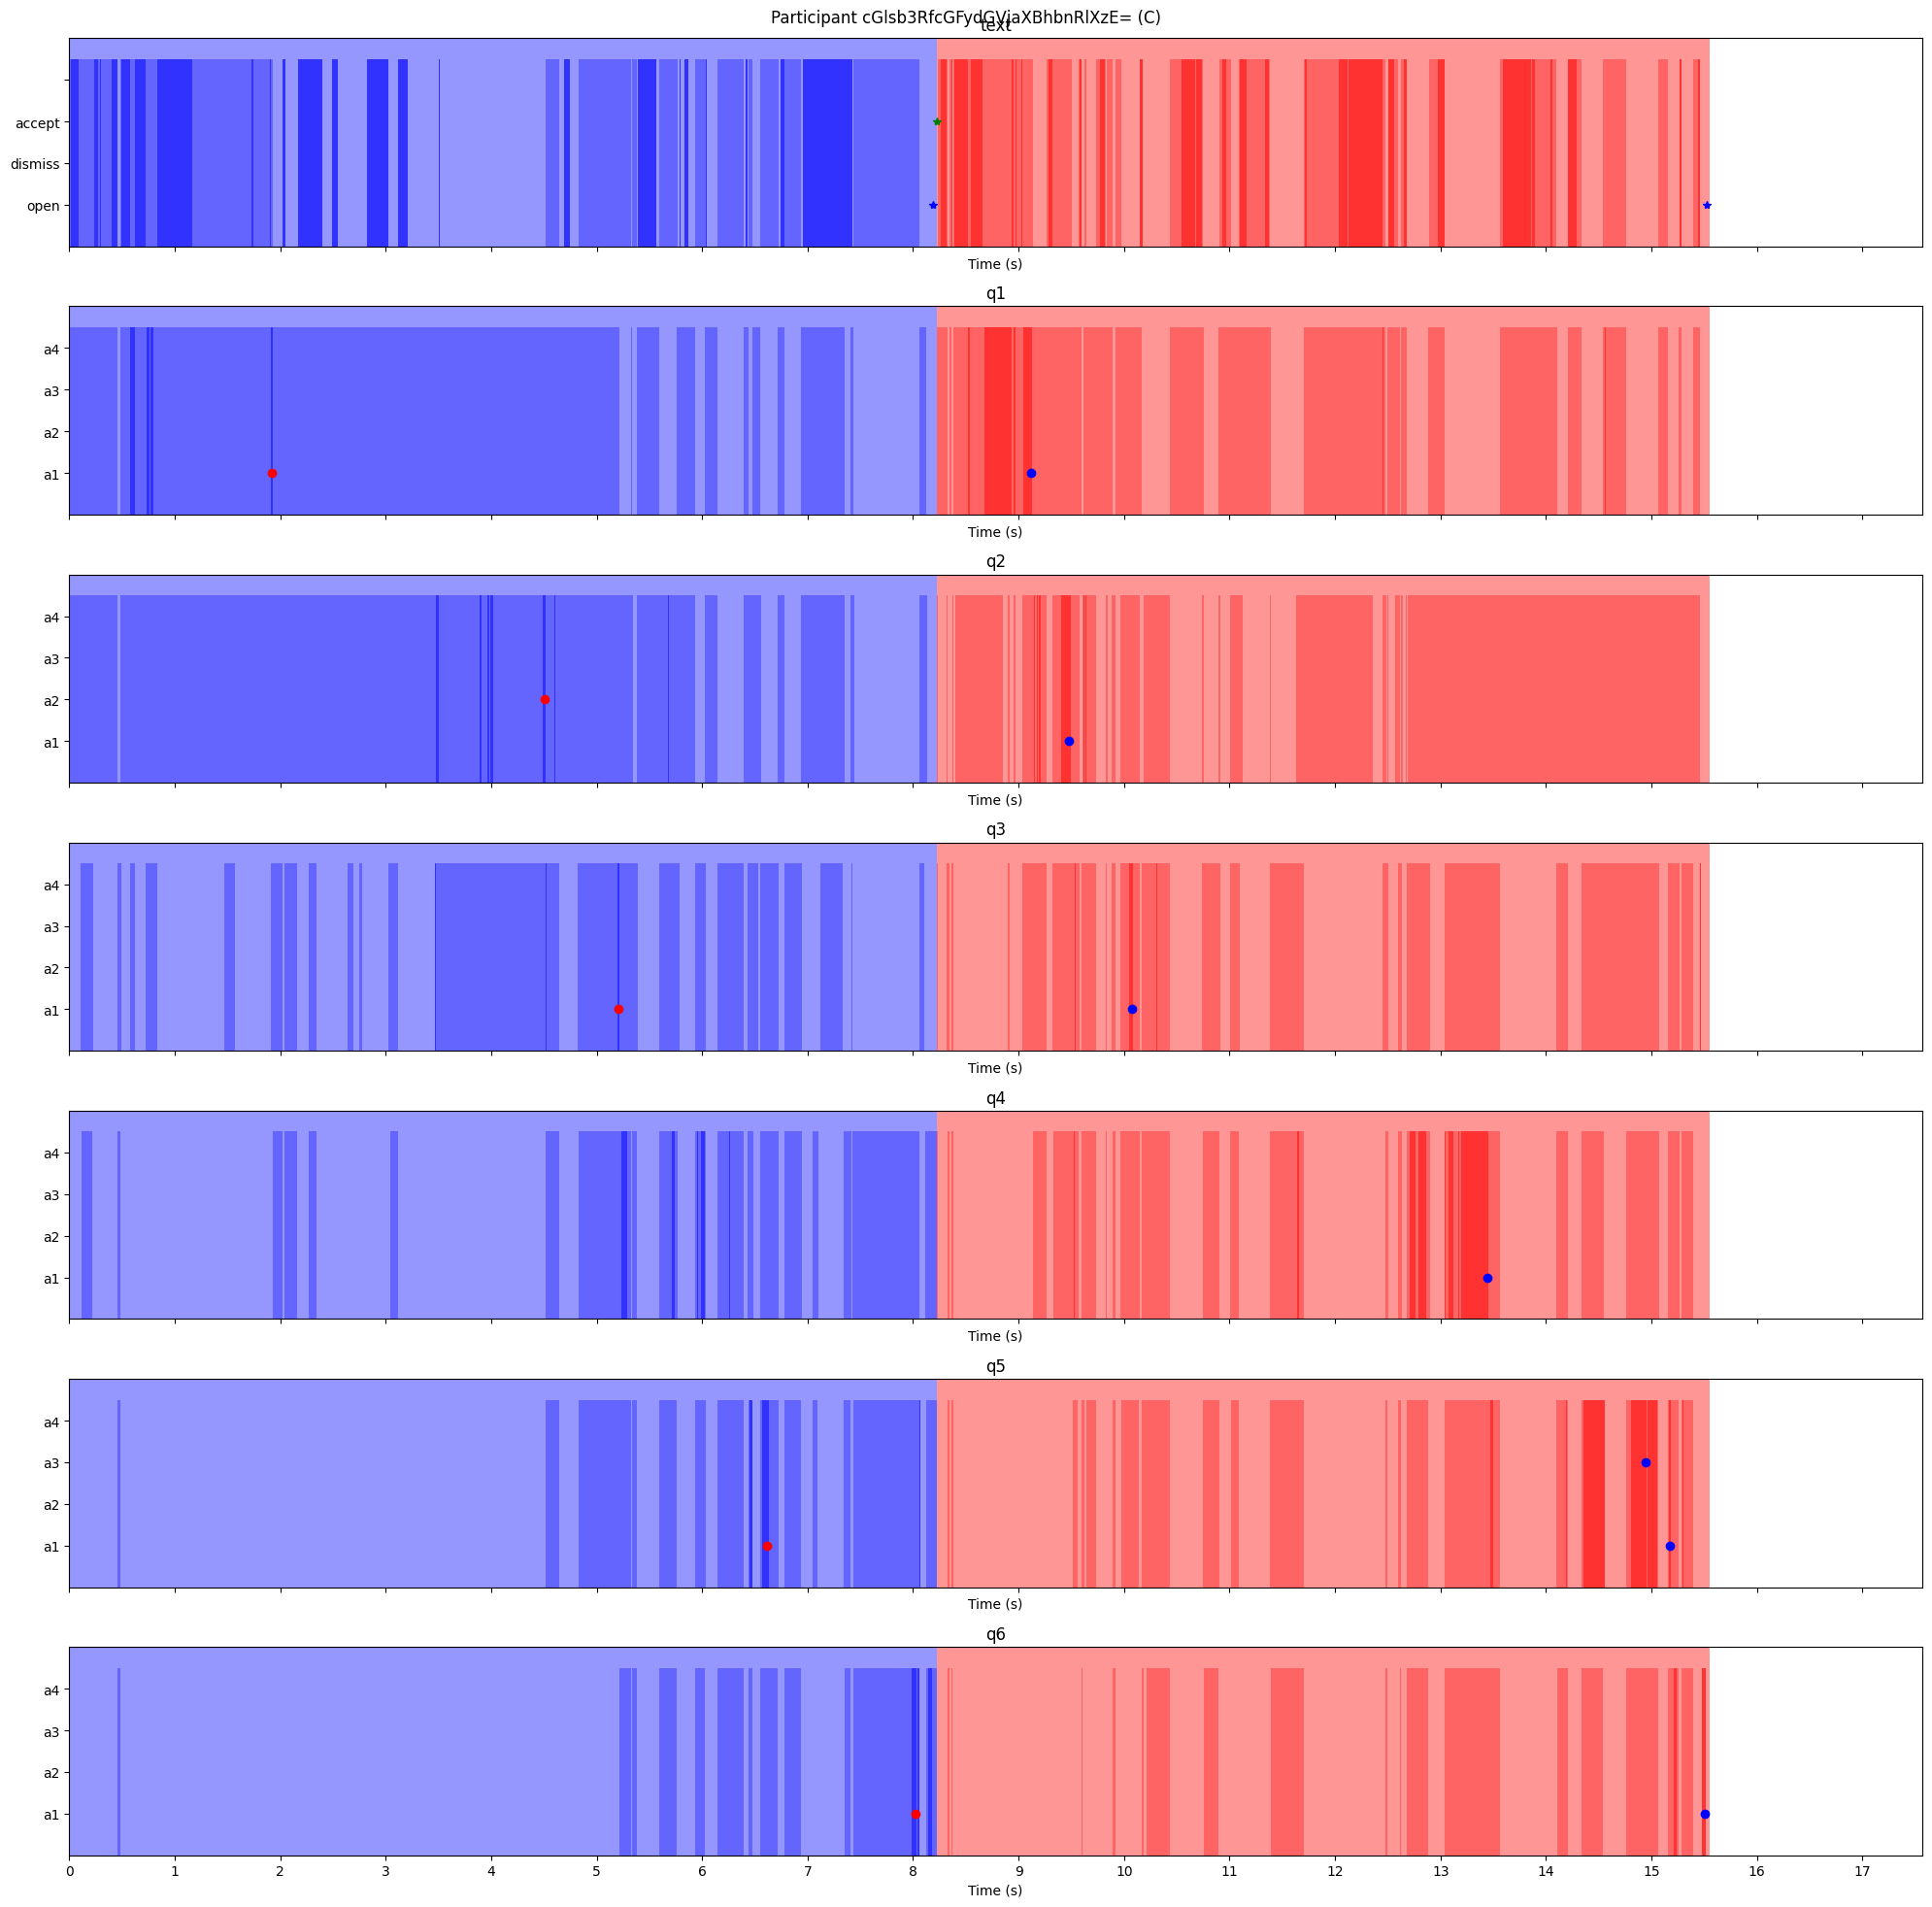

14.599999997764826


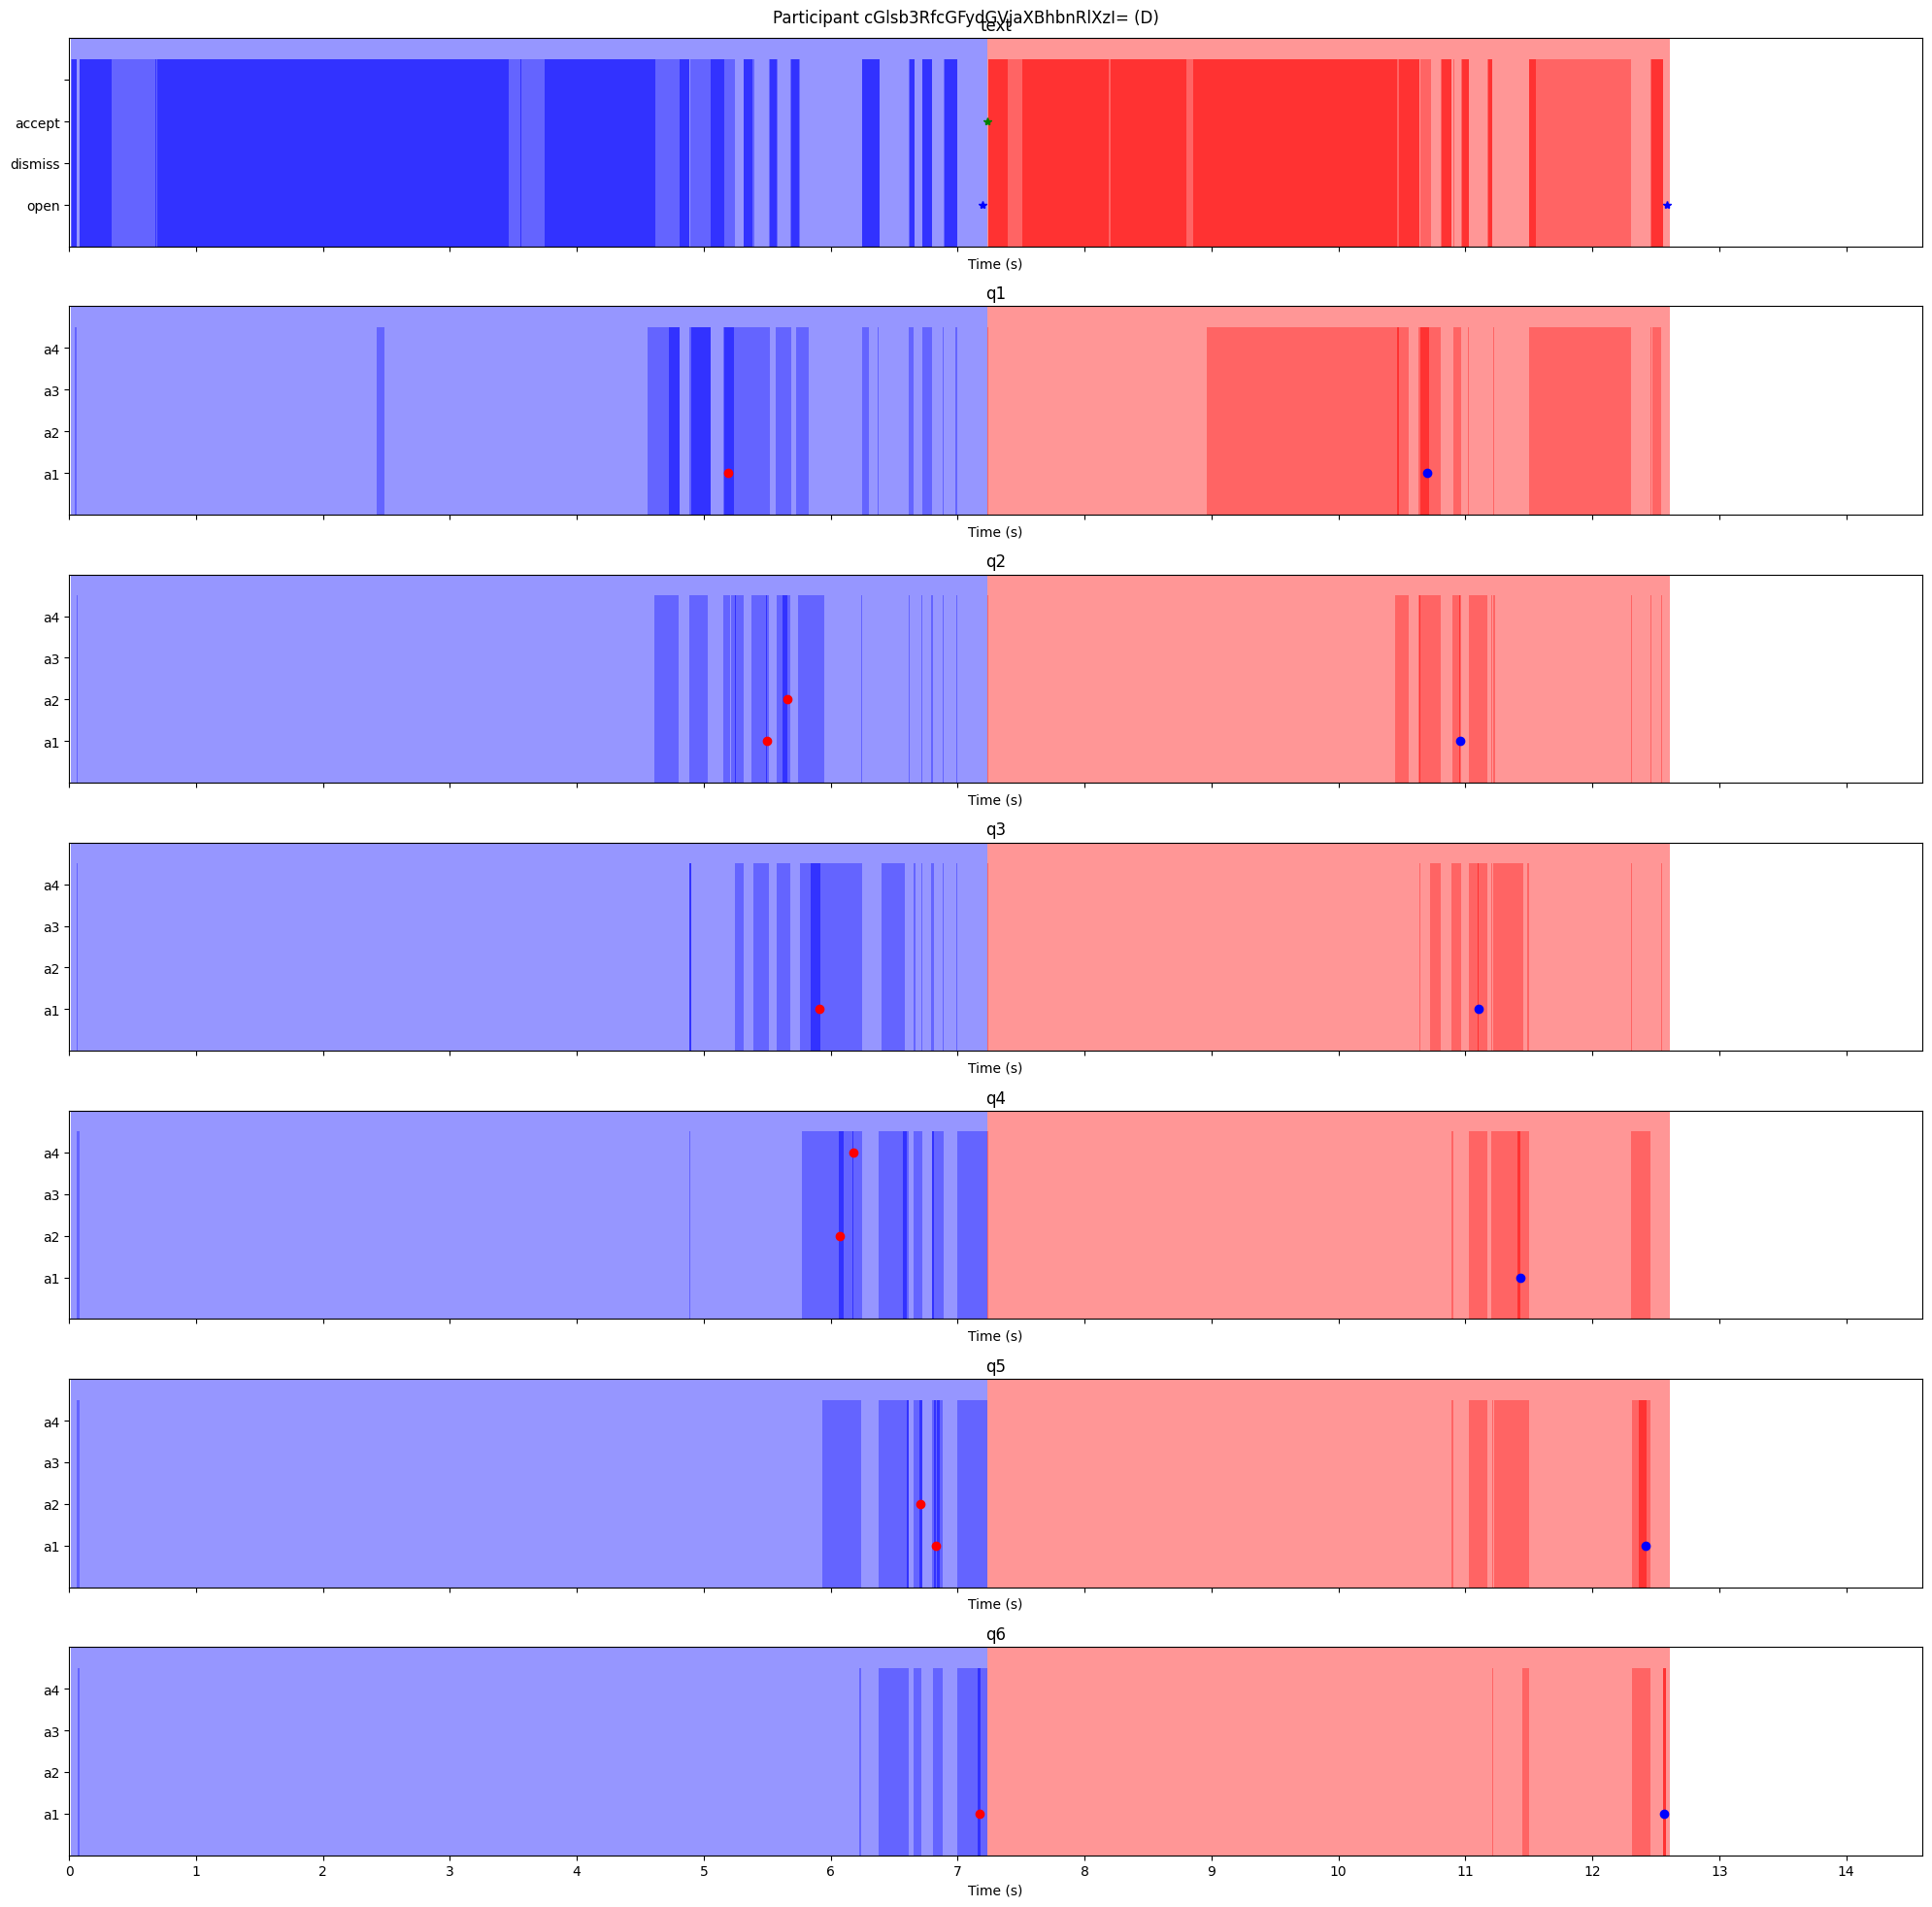

34.58333333581686


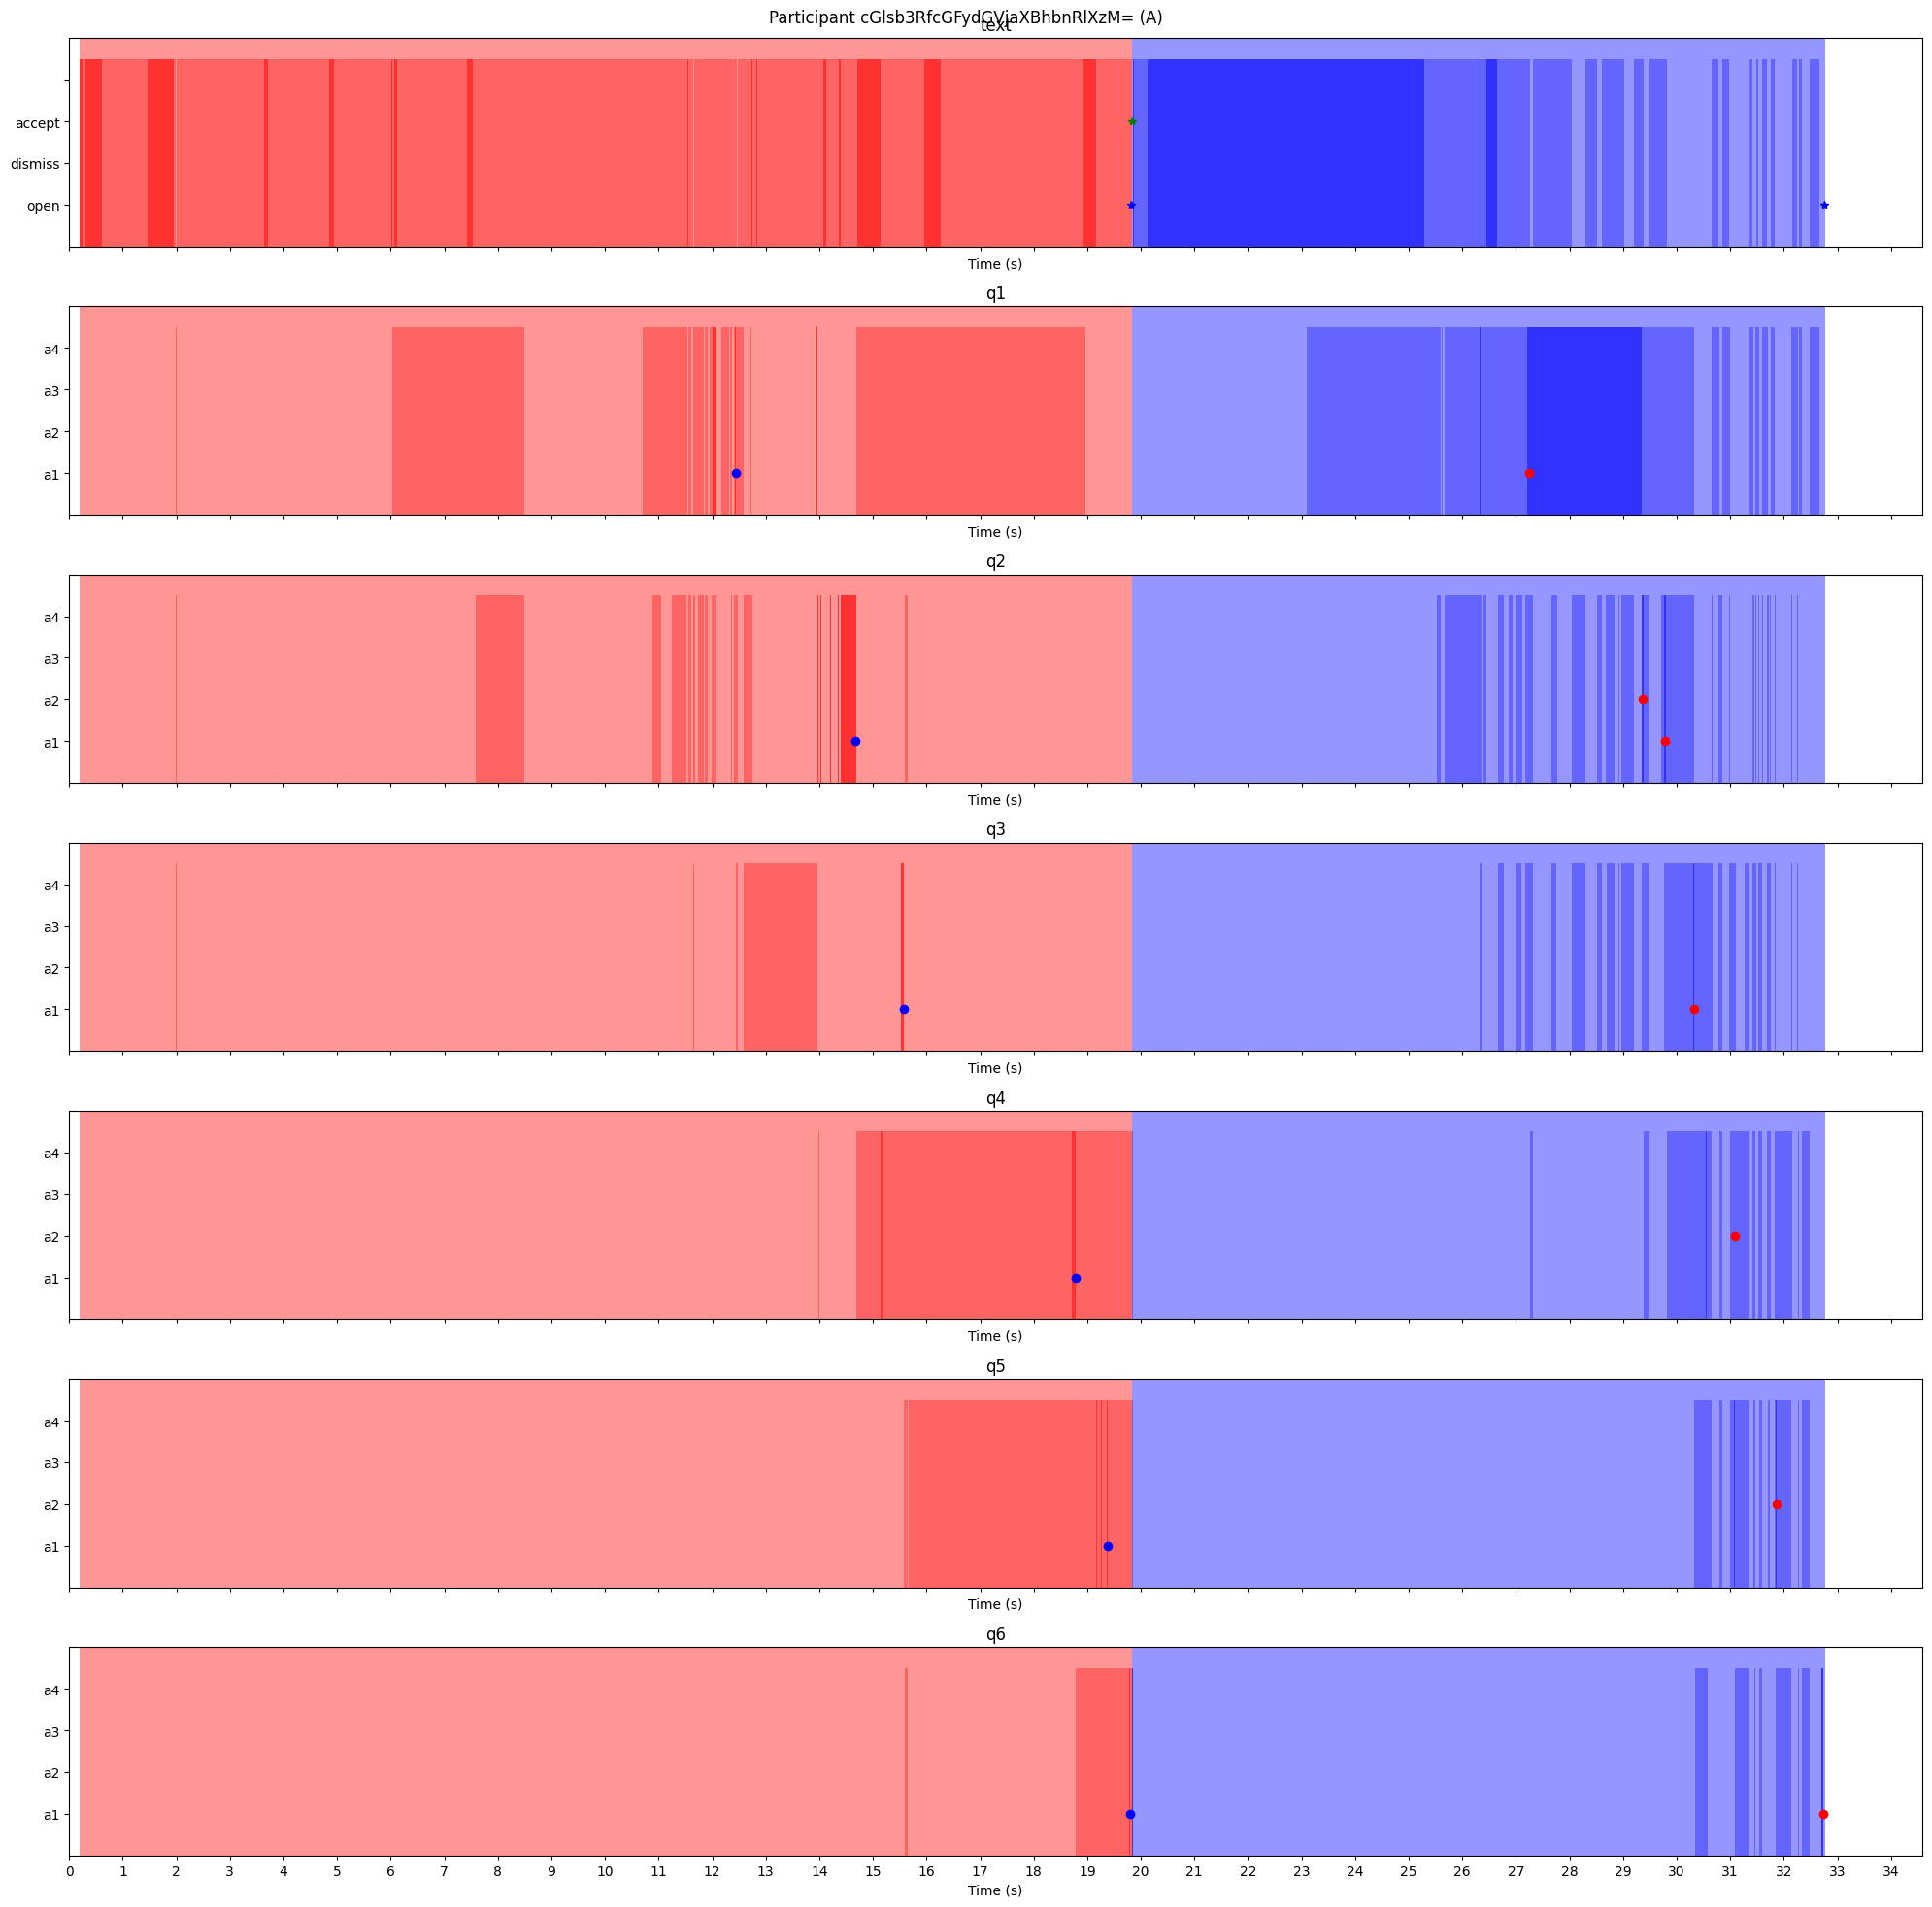

23.133333332836628


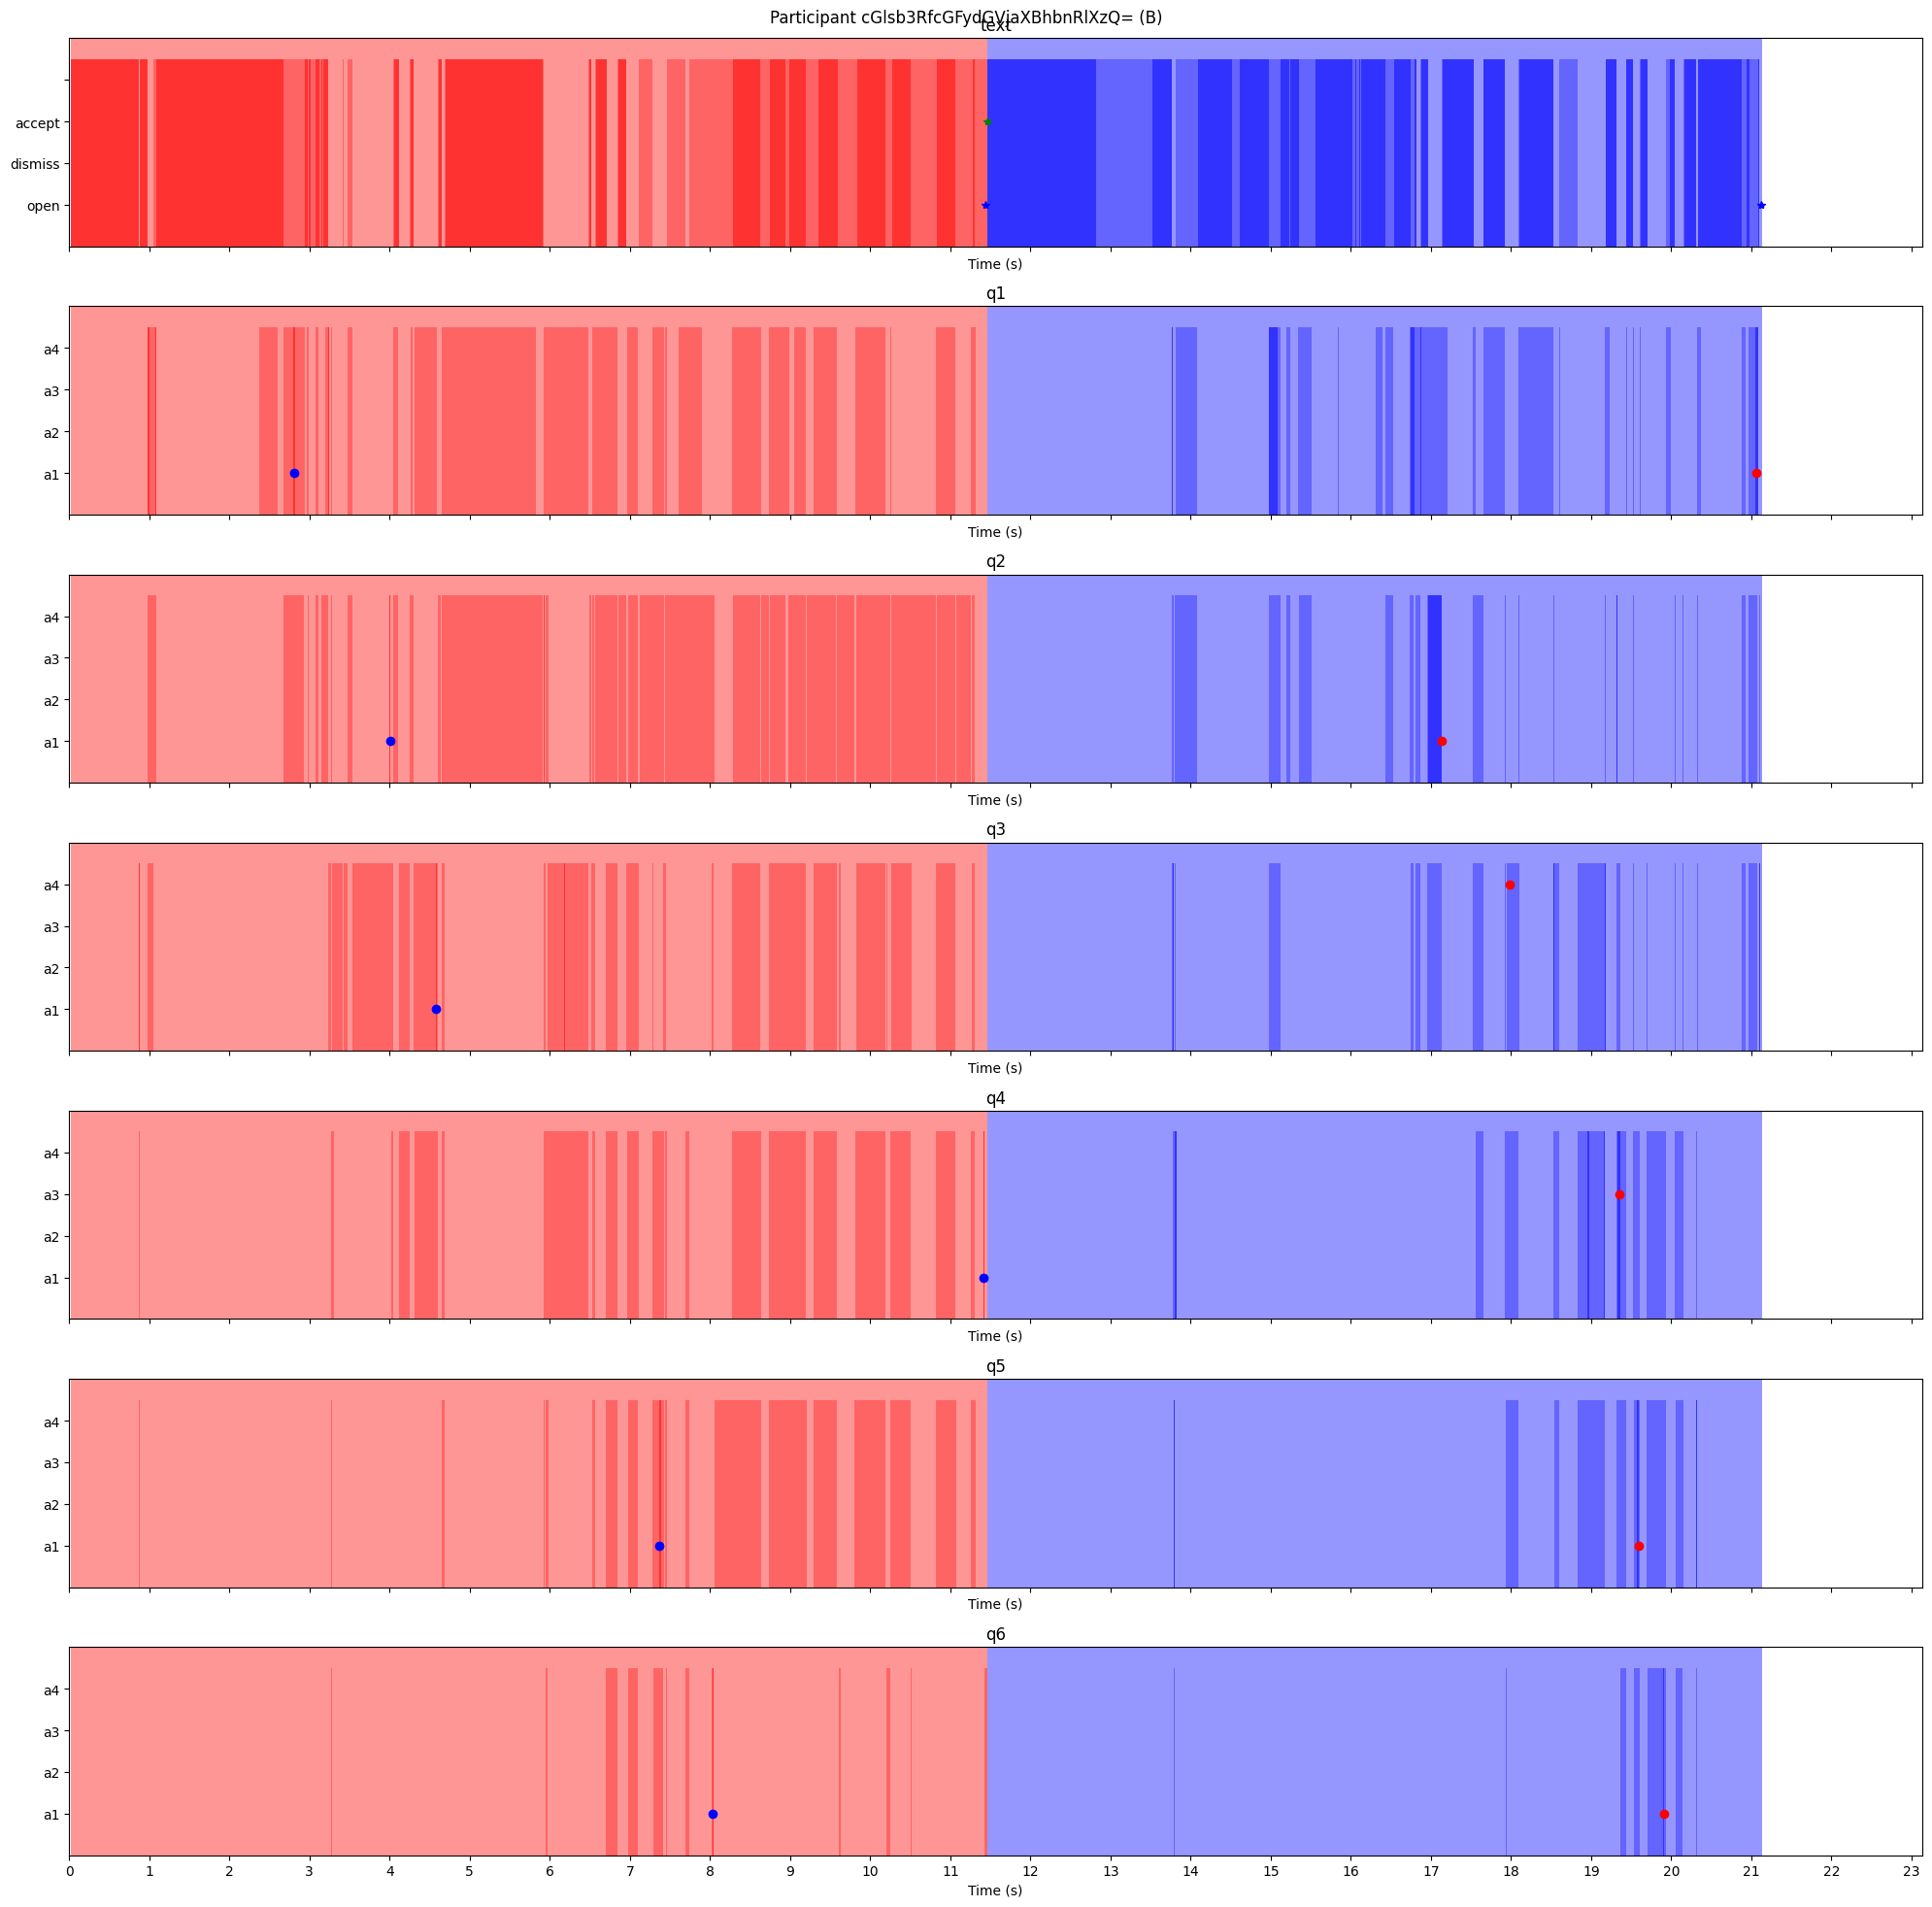

In [9]:
for participant in participant_df.to_dict(orient='records'):
  participant_id = participant['id']
  participant_group = participant['participant_group']

  start_min = (time.mktime(datetime.datetime.strptime(participant['creation_date'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) + (2 * 60 * 60)) / 60
  end_min = (time.mktime(datetime.datetime.strptime(participant['submission_date'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) + (2 * 60 * 60)) / 60
  duration = ((end_min - start_min) + 2)
  print(duration)
  
  events_list = get_events_list(survey_event_df, participant_id, start_min)

  lab1_span, lab2_span, d1_visibility_spans, d2_visibility_spans, d1_hover_spans, d2_hover_spans = evaluate_spans(events_list)
  d1_question_points, d2_question_points, d1_dialog_open_points, d2_dialog_open_points, d1_dialog_dismiss_points, d2_dialog_dismiss_points, d1_dialog_accept_points, d2_dialog_accept_points = evaluate_points(events_list)


  fig, axs = plt.subplots(7, 1, tight_layout=True, figsize=(20, 20), sharex=True)
  fig.suptitle(f'Participant {participant_id} ({participant_group})')

  # Setup axs
  for i, ax in enumerate(axs):
    ax.set_ylim(0, 5)
    ax.set_xlim(0, duration)
    ax.set_title(CHARTS_TYPE[i])
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['a1', 'a2', 'a3', 'a4'])
    ax.set_xlabel('Time (s)')
    ax.set_xticks(np.arange(0, duration, 1))
  axs[0].set_yticklabels(['open', 'dismiss', 'accept', ''])

  # Show lab spans
  for ax in axs:
    if participant_group == 'A' or participant_group == 'B':
      ax.add_patch(span_rectangle(lab1_span, 5, (255, 150, 150)))
      ax.add_patch(span_rectangle(lab2_span, 5, (150, 150, 255)))
    else:
      ax.add_patch(span_rectangle(lab1_span, 5, (150, 150, 255)))
      ax.add_patch(span_rectangle(lab2_span, 5, (255, 150, 150)))

  # Show visibility spans
  for i, TYPE in enumerate(CHARTS_TYPE):
    for span in d1_visibility_spans[TYPE]:
      axs[i].add_patch(span_rectangle(span, 4.5, (255, 100, 100)))

    for span in d2_visibility_spans[TYPE]:
      axs[i].add_patch(span_rectangle(span, 4.5, (100, 100, 255)))

  # Show hover spans
  for i, TYPE in enumerate(CHARTS_TYPE):
    for span in d1_hover_spans[TYPE]:
      axs[i].add_patch(span_rectangle(span, 4.5, (255, 50, 50)))

    for span in d2_hover_spans[TYPE]:
      axs[i].add_patch(span_rectangle(span, 4.5, (50, 50, 255)))

  # Show question points
  for i, TYPE in enumerate(CHARTS_TYPE):
    for p in d1_question_points[TYPE]:
      axs[i].plot(p[0], p[1], 'bo', label='d1')

    for p in d2_question_points[TYPE]:
      axs[i].plot(p[0], p[1], 'ro', label='d2')

  # Show dialog poins
  for p in d1_dialog_open_points:
    axs[0].plot(p[0], p[1], 'b*', label='open d1')

  for p in d2_dialog_open_points:
    axs[0].plot(p[0], p[1], 'b*', label='open d2')

  for p in d1_dialog_dismiss_points:
    axs[0].plot(p[0], p[1], 'r*', label='dismiss d1')

  for p in d2_dialog_dismiss_points:
    axs[0].plot(p[0], p[1], 'r*', label='dismiss d2')

  for p in d1_dialog_accept_points:
    axs[0].plot(p[0], p[1], 'g*', label='accept d1')

  for p in d2_dialog_accept_points:
    axs[0].plot(p[0], p[1], 'g*', label='accept d2')

  plt.show()